In [1]:
# Makes the display take up more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import gym
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class Agent():
    def __init__(self, lr, gamma, n_actions, state_space, eps_start, eps_end,
                 eps_dec):
        self.lr = lr
        self.gamma = gamma
        self.actions = [i for i in range(n_actions)]
        self.states = state_space
        self.epsilon = eps_start
        self.eps_min = eps_end
        self.eps_dec = eps_dec

        self.Q = {}

        self.init_Q()

    def init_Q(self):
        for state in self.states:
            for action in self.actions:
                self.Q[(state, action)] = 0.0

    def max_action(self, state):
        actions = np.array([self.Q[(state, a)] for a in self.actions])
        action = np.argmax(actions)

        return action

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            action = self.max_action(state)

        return action

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                if self.epsilon>self.eps_min else self.eps_min

    def learn(self, state, action, reward, state_):
        a_max = self.max_action(state_)

        self.Q[(state, action)] = self.Q[(state, action)] + self.lr*(reward +
                                        self.gamma*self.Q[(state_, a_max)] -
                                        self.Q[(state, action)])

In [4]:
class CartPoleStateDigitizer():
    def __init__(self, bounds=(2.4, 4, 0.209, 4), n_bins=10):
        """  
            bounds - bounds for linear space. Single floating point number for
                     each observation element. Space is from -bound to +bound
                     observation -> x, dx/dt, theta, dtheta/dt
        """
        self.position_space = np.linspace(-1*bounds[0], bounds[0], n_bins)
        self.velocity_space = np.linspace(-1*bounds[1], bounds[1], n_bins)
        self.pole_angle_space = np.linspace(-1*bounds[2], bounds[2], n_bins)
        self.pole_velocity_space = np.linspace(-1*bounds[3], bounds[3], n_bins)
        self.states = self.get_state_space()

    def get_state_space(self):
        states = []
        for i in range(len(self.position_space)+1):
            for j in range(len(self.velocity_space)+1):
                for k in range(len(self.pole_angle_space)+1):
                    for l in range(len(self.pole_velocity_space)+1):
                        states.append((i,j,k,l))
        return states

    def digitize(self, observation):
        x, dx_dt, theta, dtheta_dt = observation
        cart_x = int(np.digitize(x, self.position_space))
        cart_dx_dt = int(np.digitize(dx_dt, self.velocity_space))
        pole_theta = int(np.digitize(theta, self.pole_angle_space))
        pole_dtheta_dt = int(np.digitize(dtheta_dt, self.pole_velocity_space))

        return (cart_x, cart_dx_dt, pole_theta, pole_dtheta_dt)

In [5]:
def plot_learning_curve(scores, x):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of scores')
    plt.show()

In [6]:
env = gym.make('CartPole-v0')
n_games = 30000
eps_dec =  2 / n_games
digitizer = CartPoleStateDigitizer()
agent = Agent(lr=0.01, gamma=0.99, n_actions=2, eps_start=1.0,
        eps_end=0.01, eps_dec=eps_dec, state_space=digitizer.states)

scores = []

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    state = digitizer.digitize(observation)
    while not done:
        action = agent.choose_action(state)
        observation_, reward, done, info = env.step(action)
        state_ = digitizer.digitize(observation_)
        agent.learn(state, action, reward, state_)
        state = state_
        score += reward
    if i % 5000 == 0:
        print('episode ', i, 'score %.1f' % score, 
              'epsilon %.2f' % agent.epsilon)

    agent.decrement_epsilon()
    scores.append(score)

episode  0 score 28.0 epsilon 1.00
episode  5000 score 24.0 epsilon 0.67
episode  10000 score 67.0 epsilon 0.33
episode  15000 score 122.0 epsilon 0.01
episode  20000 score 141.0 epsilon 0.01
episode  25000 score 106.0 epsilon 0.01


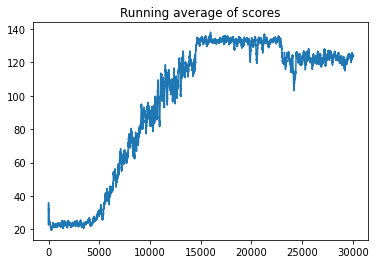

In [7]:
x = [i + 1 for i in range(n_games)]
plot_learning_curve(scores, x)

In [8]:
import datetime as dt
end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')

Finished: Saturday February 12, 2022 at 14:40
